# Machine learning: advanced computer based models

# Scikit-learn

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import numpy.random as rnd

#plt.style.use('fivethirtyeight')

#print(plt.rcParams)

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['figure.facecolor'] = 'w'
#plt.rcParams['grid.linestyle'] = 'dashed'
#plt.rcParams['axes.grid'] = False
#plt.rcParams['font.size'] = 15
#plt.rcParams['axes.edgecolor'] = '#afafaf'
#plt.rcParams['grid.color'] = '#afafaf'
#plt.rcParams['axes.facecolor'] = 'w'
#plt.rcParams['figure.facecolor'] = 'w'

In [2]:
import os
plt.style.use(os.path.join(os.getcwd(), 'mystyle.mplstyle') )
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['figure.facecolor'] = 'w'
#plt.rcParams['grid.linestyle'] = 'dashed'
#plt.rcParams['axes.grid'] = False
#plt.rcParams['font.size'] = 15
plt.rcParams['axes.edgecolor'] = 'w'
#plt.rcParams['grid.color'] = '#afafaf'
#plt.rcParams['axes.facecolor'] = 'w'
#plt.rcParams['figure.facecolor'] = 'w'


In [3]:
import sklearn
sklearn.__version__

'0.17'

In [4]:
def despine(axs):
    # to be able to handle subplot grids
    # it assumes the input is a list of 
    # axes instances, if it is not a list, 
    # it puts it in one
    if type(axs) != type([]):
        axs = [axs]
    for ax in axs:
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        ax.spines['bottom'].set_position(('outward', 10))
        ax.spines['left'].set_position(('outward', 10))

# Linear regression

## Climate data

In [5]:
co2_gr = pd.read_csv('data/co2_gr_gl.txt', 
                  delim_whitespace=True,
                 skiprows=62,
                 names=['year', 'rate', 'err'])

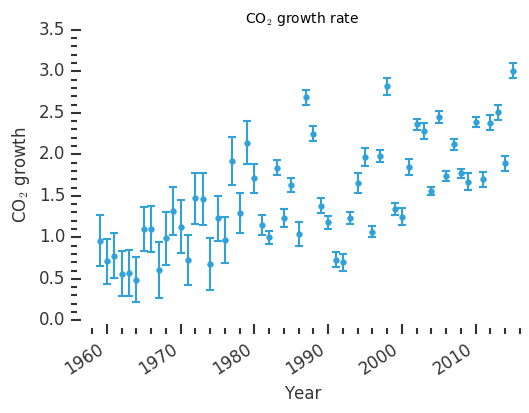

In [6]:
fig, ax = plt.subplots(1,1)
ax.errorbar(co2_gr['year'], co2_gr['rate'], 
           yerr=co2_gr['err'],
           ls='None',  
           elinewidth=1.5,
           capthick=1.5,
           marker='.',
           ms=8)
despine(ax)
plt.minorticks_on()
labels = ax.get_xticklabels()
plt.setp(labels, rotation=33, ha='right')
ax.set_ylabel('CO$_2$ growth')
ax.set_xlabel('Year')
ax.set_xlim((1957,2016))
ax.set_title('CO$_2$ growth rate');

In [7]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import cross_validation

In [8]:
x_test, x_train, y_test, y_train = cross_validation.train_test_split(
    co2_gr['year'], co2_gr['rate'], 
    test_size=0.75, 
    random_state=0)
X_train = x_train[:, np.newaxis]
X_test = x_test[:, np.newaxis]
line_x = np.array([1955, 2025])

In [9]:
est_lin = LinearRegression()
est_lin.fit(X_train, y_train)
lin_pred = est_lin.predict(line_x.reshape(-1, 1))

In [10]:
est_lasso = Lasso(alpha=0.7)
est_lasso.fit(X_train, y_train)
lasso_pred = est_lasso.predict(line_x.reshape(2, 1))

In [11]:
def printstuff(estimator, A, b):
    name = estimator.__str__().split('(')[0]
    print('+'*6, name, '+'*6)
    print('Slope: {0:.3f} Intercept:{1:.2f} '.format(
            estimator.coef_[0], estimator.intercept_))
    print("Mean squared residuals: {0:.2f}".format(
          np.mean((estimator.predict(A) - b)**2)) ) 
    print('Variance score: {0:.2f}'.format(
            estimator.score(A, b)) )

In [12]:
printstuff(est_lin, X_test, y_test)
printstuff(est_lasso, X_test, y_test)

++++++ LinearRegression ++++++
Slope: 0.027 Intercept:-51.60 
Mean squared residuals: 0.17
Variance score: 0.56
++++++ Lasso ++++++
Slope: 0.024 Intercept:-46.16 
Mean squared residuals: 0.17
Variance score: 0.56


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_train, y_train, marker='s',
        label='Train', color='IndianRed')
ax.scatter(X_test, y_test, label='Test', 
        color='SteelBlue')
ax.plot(line_x, lin_pred, color='Green',
        label='Linreg', lw=2)
ax.plot(line_x, lasso_pred, color='Coral',
        dashes=(5,4), label='LASSO', lw=2)
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ growth rate')
ax.legend(loc=2, fontsize=10, numpoints=1)
despine(ax)
plt.minorticks_on()
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=7)
ax.set_xlim(1950,2030)
ax.set_title('CO$_2$ growth rate');

In [14]:
from sklearn.metrics import r2_score
r2_lin = r2_score(co2_gr['rate'], 
                  est_lin.predict(
                    co2_gr['year'].reshape(-1,1)))
r2_lasso = r2_score(co2_gr['rate'], 
                    est_lasso.predict(
                        co2_gr['year'].reshape(-1,1)))
print('LinearSVC: {0:.2f}\nLASSO:\
\t   {1:.2f}'.format(r2_lin, r2_lasso))

LinearSVC: 0.49
LASSO:	   0.48


## Checking with Bayesian analysis and OLS

In [15]:
import pymc
x = co2_gr['year'].as_matrix()  
y = co2_gr['rate'].as_matrix()
y_error = co2_gr['err'].as_matrix()
def model(x, y): 
    slope = pymc.Normal('slope', 0.1, 1.)
    intercept = pymc.Normal('intercept', -50., 10.)
    @pymc.deterministic(plot=False)
    def linear(x=x, slope=slope, intercept=intercept):
        return x * slope + intercept
    f = pymc.Normal('f', mu=linear, tau=1.0/y_error, value=y, observed=True)
    return locals()
MDL = pymc.MCMC(model(x,y))
MDL.sample(5e5, 5e4, 100)
y_fit = MDL.stats()['linear']['mean']
slope = MDL.stats()['slope']['mean']
intercept = MDL.stats()['intercept']['mean']

 [-----------------99%----------------- ] 495797 of 500000 complete in 80.6 secHalting at iteration  498493  of  500000


In [16]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
ols_results = smf.ols("rate ~ year", co2_gr).fit()
ols_params = np.flipud(ols_results.params)

## Comparison

In [17]:
print('     Slope  Intercept \nML : \
{0:.3f} {1:.3f} \nOLS: {2:.3f} \
{3:.3f} \nBay: {4:.3f} \
{5:.3f}'.format(est_lin.coef_[0], 
                est_lin.intercept_,
                ols_params[0],
                ols_params[1],
                slope,
               intercept) )

     Slope  Intercept 
ML : 0.027 -51.597 
OLS: 0.027 -51.812 
Bay: 0.026 -50.018


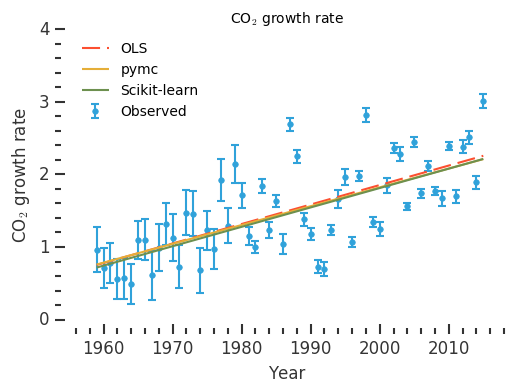

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, yerr=y_error, ls='None',  
        elinewidth=1.5, capthick=1.5,
        marker='.', ms=8, label='Observed')
ax.set_xlabel('Year')
ax.set_ylabel('CO$_2$ growth rate')
ax.plot([x.min(), x.max()], 
        [ols_results.fittedvalues.min(), 
         ols_results.fittedvalues.max()], 
        lw=1.5, label='OLS',
        dashes=(13,5))
ax.plot(x, y_fit, lw=1.5,
        label='pymc')
ax.plot([x.min(), x.max()], 
        est_lin.predict([[x.min(), ], [x.max(), ]]),
        label='Scikit-learn', lw=1.5)
despine(ax)
plt.minorticks_on()
ax.locator_params(axis='x', nbins=7)
ax.locator_params(axis='y', nbins=4)
ax.set_xlim((1955,2018))
ax.legend(loc=2, numpoints=1)
ax.set_title('CO$_2$ growth rate');

# Clustering

In [19]:
TABLE_FILE = 'data/data_ch5_clustering.pick'
mycat = pd.read_pickle(TABLE_FILE)

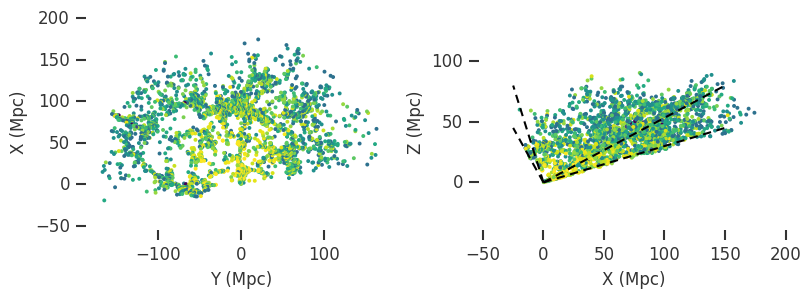

In [20]:
fig,ax = plt.subplots(1,2, figsize=(8,2.5))
plt.subplot(121)
plt.scatter(mycat['Y'], -1*mycat['X'], 
            s=8, 
            color=plt.cm.viridis_r(10**(mycat.Zmag-mycat.Zmag.max()) ), 
            edgecolor='None')
plt.xlabel('Y (Mpc)'); plt.ylabel('X (Mpc)')
ax = plt.gca()
despine(ax)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
plt.axis('equal')
plt.subplot(122)
c_arr = 10**(mycat.Zmag-mycat.Zmag.max())
plt.scatter(-1*mycat['X'],mycat['Z'], 
            s=8, 
            color=plt.cm.viridis_r(c_arr), 
            edgecolor='None')
lstyle = dict(lw=1.5, color='k', dashes=(6,4))
ax = plt.gca()
despine(ax)
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=5)
plt.plot([0,150], [0,80], **lstyle)
plt.plot([0,150], [0,45], **lstyle)
plt.plot([0,-25], [0,80], **lstyle)
plt.plot([0,-25], [0,45], **lstyle)
plt.xlabel('X (Mpc)'); plt.ylabel('Z (Mpc)')
plt.subplots_adjust(wspace=0.3)
plt.axis('equal');
plt.ylim((-10,110));

In [21]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [22]:
A = np.array([mycat['Y'], -1*mycat['X'], mycat['Z']]).T
#A = np.array([mycat['Y'], -1*mycat['X']]).T
A_scaled = StandardScaler().fit_transform(A)
dbout = DBSCAN(eps=0.15, min_samples=5).fit(A_scaled)

In [23]:
(dbout.labels_==-1).any()

True

In [24]:
csmask = np.zeros_like(dbout.labels_, dtype=bool)
csmask[dbout.core_sample_indices_] = True
unique_labels = set(dbout.labels_)

In [25]:
n_clusters = len(set(labels)) - [0,1][-1 in labels]

print('Estimated number of clusters: %d' % n_clusters)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(A_scaled, dbout.labels_))

Estimated number of clusters: 8
Silhouette Coefficient: -0.143


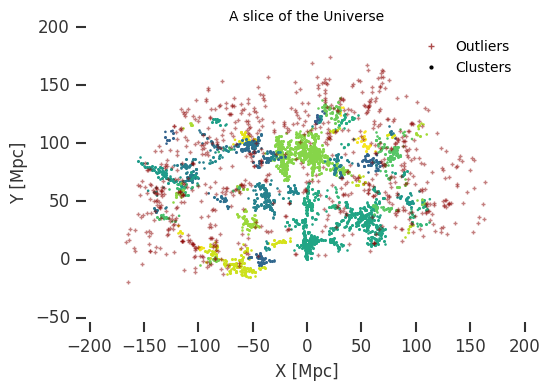

In [26]:
colors = plt.cm.viridis(np.linspace(0.3, 1, len(unique_labels))) 
np.random.seed(0)
np.random.shuffle(colors)

for lbl, col in zip(unique_labels, colors):
    if lbl == -1:
        # Black used for noise.
        col = 'DarkRed'; m1=m2= '+'; s = 10; a = 0.5
    else:
        m1='.';m2='.'; s=5; a=1
    cmmask = (dbout.labels_ == lbl)
    xy = A[cmmask & csmask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col,
                marker=m1,
                s=s+1,
               alpha=a)
    xy = A[cmmask & ~csmask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col,
                marker=m2,
                s=s-2,
               alpha=a)
despine(plt.gca())
noiseArtist = plt.Line2D((0,1),(0,0), 
                       color='DarkRed', 
                       marker='+', 
                       linestyle='',
                       ms=4, mew=1,
                       alpha=0.7)
clusterArtist = plt.Line2D((0,1),(0,0), 
                       color='k', 
                       marker='.', 
                       linestyle='',
                      ms=4, mew=1)
plt.legend([noiseArtist, clusterArtist], 
           ['Outliers','Clusters'], 
           numpoints=1)
plt.title('A slice of the Universe')
plt.xlabel('X [Mpc]')
plt.ylabel('Y [Mpc]');

# Seeds classification

In [27]:
%%bash
less data/seeds.desc

Couldn't find program: 'bash'


In [28]:
more data/seeds.desc

In [29]:
seeds = pd.read_csv('data/seeds_dataset.txt',
                delim_whitespace=True,
                names=['A', 'P', 'C', 'lkern', 'wkern', 'asym', 'lgro', 'gr'])

In [30]:
seeds.head()

,A,P,C,lkern,wkern,asym,lgro,gr
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## Visualize the data

In [31]:
gr1 = seeds.gr == 1
gr2 = seeds.gr == 2
gr3 = seeds.gr == 3

In [32]:
pars = ['A','C','P','asym','lgro','lkern','wkern']

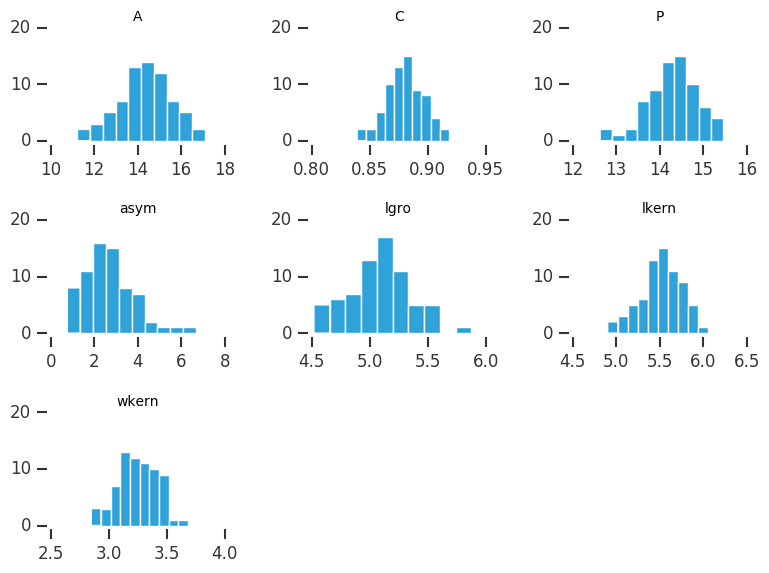

In [33]:
axes = seeds[pars][gr1].hist(figsize=(8,6))
despine(list(axes.flatten()))
_ = [ax.grid() for ax in list(axes.flatten())]
_ = [ax.locator_params(axis='x', nbins=4) for ax in list(axes.flatten())]
_ = [ax.locator_params(axis='y', nbins=2) for ax in list(axes.flatten())]
plt.subplots_adjust(wspace=0.5, hspace=0.7)

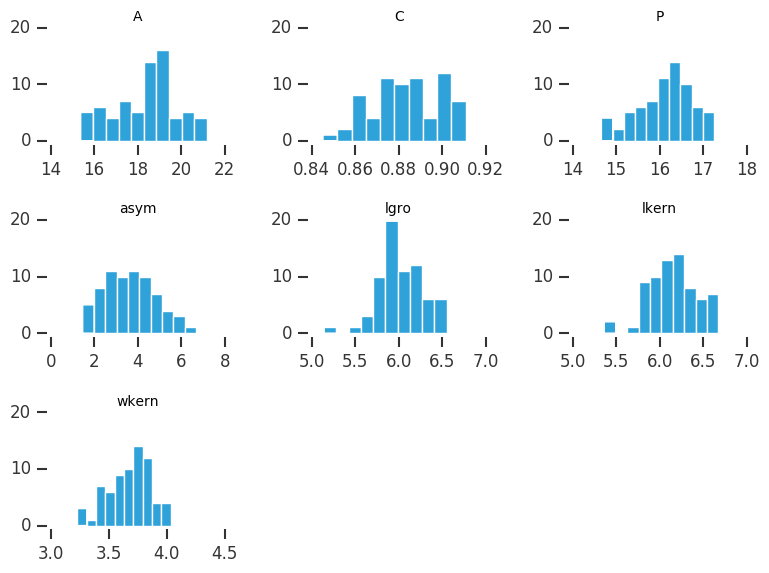

In [34]:
axes = seeds[pars][gr2].hist(figsize=(8,6))
despine(list(axes.flatten()))
_ = [ax.grid() for ax in list(axes.flatten())]
_ = [ax.locator_params(axis='x', nbins=4) for ax in list(axes.flatten())]
_ = [ax.locator_params(axis='y', nbins=2) for ax in list(axes.flatten())]
plt.subplots_adjust(wspace=0.5, hspace=0.7)

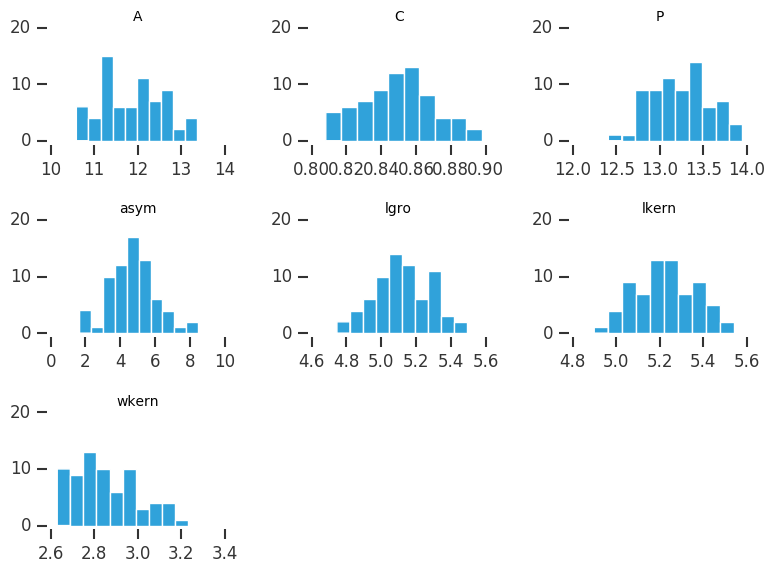

In [35]:
axes = seeds[pars][gr3].hist(figsize=(8,6))
despine(list(axes.flatten()))
_ = [ax.grid() for ax in list(axes.flatten())]
_ = [ax.locator_params(axis='x', nbins=5) for ax in list(axes.flatten())]
_ = [ax.locator_params(axis='y', nbins=2) for ax in list(axes.flatten())]
plt.subplots_adjust(wspace=0.5, hspace=0.7)

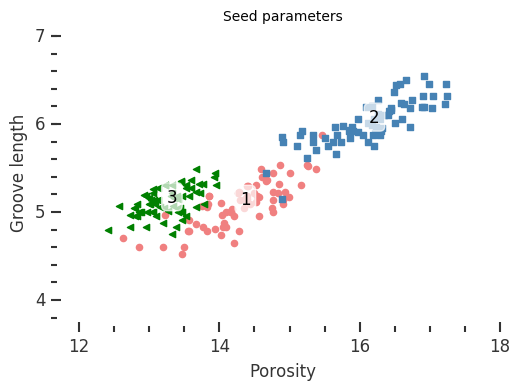

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(seeds.P[gr1], seeds.lgro[gr1], 
           color='LightCoral') 
ax.scatter(seeds.P[gr2], seeds.lgro[gr2], 
           color='SteelBlue', marker='s') 
ax.scatter(seeds.P[gr3], seeds.lgro[gr3], 
           color='Green',  marker='<');
ax.text(seeds.P[gr1].mean(), seeds.lgro[gr1].mean(),
        '1', bbox=dict(color='w', alpha=0.7, 
                 boxstyle="Round"))
ax.text(seeds.P[gr2].mean(), seeds.lgro[gr2].mean(),
        '2', bbox=dict(color='w', alpha=0.7, 
                  boxstyle="Round"))
ax.text(seeds.P[gr3].mean(), seeds.lgro[gr3].mean(),
        '3', bbox=dict(color='w', alpha=0.7, 
                 boxstyle="Round"))
ax.set_xlabel('Porosity')
ax.set_ylabel('Groove length')
ax.set_title('Seed parameters')
despine(ax)
plt.minorticks_on()
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=4)
ax.set_xlim(11.8,18)
ax.set_ylim(3.8,7.1);

## Feature selection

In [37]:
X_raw = seeds.as_matrix()
X_pre, labels = X_raw[:,:-1], X_raw[:,-1]

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_best = SelectKBest(chi2, k=2).fit_transform(X_pre, labels)
X_best.shape

(210, 2)

In [39]:
X_best[:5]

array([[ 15.26 ,   2.221],
       [ 14.88 ,   1.018],
       [ 14.29 ,   2.699],
       [ 13.84 ,   2.259],
       [ 16.14 ,   1.355]])

In [40]:
seeds.head()

,A,P,C,lkern,wkern,asym,lgro,gr
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


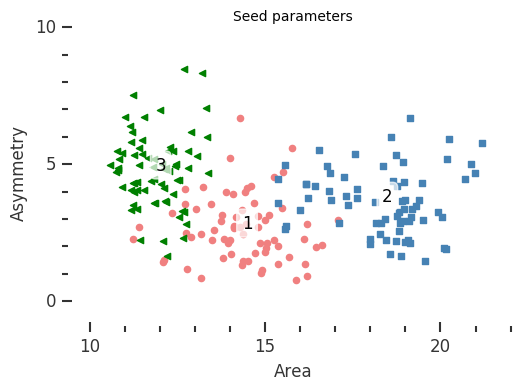

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(seeds.A[gr1], seeds.asym[gr1], 
           color='LightCoral')
ax.text(seeds.A[gr1].mean(), seeds.asym[gr1].mean(),
        '1', bbox=dict(color='w', alpha=0.7, 
                 boxstyle="Round"))
ax.scatter(seeds.A[gr2], seeds.asym[gr2], 
           color='SteelBlue',
           marker='s') 
ax.text(seeds.A[gr2].mean(), seeds.asym[gr2].mean(),
        '2', bbox=dict(color='w', alpha=0.7, 
                  boxstyle="Round"))
ax.scatter(seeds.A[gr3], seeds.asym[gr3], 
           color='Green',
           marker='<')
ax.text(seeds.A[gr3].mean(), seeds.asym[gr3].mean(),
        '3', bbox=dict(color='w', alpha=0.7, 
                 boxstyle="Round"))

ax.set_xlabel('Area')
ax.set_ylabel('Asymmetry')
ax.set_title('Seed parameters')
despine(ax)
plt.minorticks_on()
ax.locator_params(axis='x', nbins=5)
ax.locator_params(axis='y', nbins=3)

ax.set_xlim(9.6,22)
ax.set_ylim(-0.6,10);

## Classifying the data

In [42]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
res = 0.01
X, y  = X_best[::2], labels[::2]
X, y  = X_best, labels
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, res),
                     np.arange(y_min, y_max, res))

In [43]:
def plot_results(clf, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    xxyy = np.vstack((xx.flatten(), yy.flatten())).T
    Z = clf.predict(xxyy)
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z, 
               colors=['Green','LightCoral', 'SteelBlue'], 
               alpha=0.7, zorder=-1)
    ax.scatter(seeds.A[gr1], seeds.asym[gr1], 
               color='LightCoral') 
    ax.scatter(seeds.A[gr2], seeds.asym[gr2], 
               color='SteelBlue',  marker='s') 
    ax.scatter(seeds.A[gr3], seeds.asym[gr3], 
               color='Green', marker='<')
    ax.text(seeds.A[gr1].mean(), seeds.asym[gr1].mean(),
            '1', bbox=dict(color='w', alpha=0.7, 
                     boxstyle="Round"))
    ax.text(seeds.A[gr2].mean(), seeds.asym[gr2].mean(),
            '2', bbox=dict(color='w', alpha=0.7, 
                      boxstyle="Round"))
    ax.text(seeds.A[gr3].mean(), seeds.asym[gr3].mean(),
            '3', bbox=dict(color='w', alpha=0.7, 
                     boxstyle="Round"))
    despine(ax)
    plt.minorticks_on()
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=3)
    ax.set_xlabel('Area')
    ax.set_ylabel('Asymmetry')
    ax.set_title(title, size=10)
    ax.set_xlim(9.6,22)
    ax.set_ylim(-0.6,10);

### SVC - linear kernel

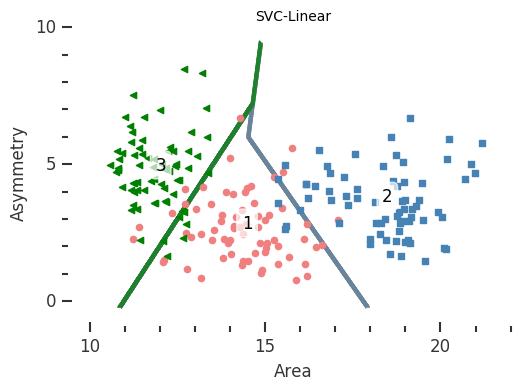

In [ ]:
svc = svm.SVC(kernel='linear', C=1.).fit(X, y)
plot_results(svc, 'SVC-Linear')

### SVC RBF

In [ ]:
rbf_svc = svm.SVC(kernel='rbf', gamma=0.4, C=1.).fit(X, y)
plot_results(rbf_svc, 'SVC-Radial Basis Function')

### SVC polynomial

In [ ]:
poly_svc = svm.SVC(kernel='poly', degree=3, C=1.).fit(X, y)
plot_results(poly_svc, 'SVC-Polynomial')

### kNN

In [ ]:
knn = KNeighborsClassifier(weights = 'uniform', n_neighbors=5).fit(X, y)
plot_results(knn, 'k-Nearest Neighbours')

In [ ]:
rfc = RandomForestClassifier(max_depth=3, n_estimators=10,
                             max_features='auto'
                             ).fit(X, y)
plot_results(rfc, 'Random Forest')